In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [2]:
import autoencoder.aecExtraFeatures as Z_calculations

def addZToPrediction(model, data_point):
    reconstruction = model.decoder(model.encoder(data_point))

    Z_features = [Z_calculations.getZVector(data_point, reconstruction)]

    Z_features_tensor = tf.convert_to_tensor(Z_features, dtype=tf.float32)
    data_point = tf.convert_to_tensor(data_point, dtype=tf.float32)

    data_point = tf.concat([data_point, Z_features_tensor], 1)

    return data_point

In [3]:
def isAnomaly(data_point, model_1, model_2, threshold):

    # need autoencoder to return boolean isAnomaly
    isAnomaly = tf.math.less(tf.keras.losses.mae(model_1(data), data), threshold)

    # if the autoencoder doesn't find anything out of the ordinary, return False
    if not isAnomaly:
        return False

    data_point = addZToPrediction(model_1, data_point)

    # if the autoencoder sees something weird, run it through the isolation forest to make sure
    return model_2.predict(data_point)

In [4]:
from turtleIsolationForests.preprocessFeatures import preprocess_features

train_dataframe = pd.read_csv("eda_simple_classification/network_data_mod_train.csv", index_col=0)
test_dataframe = pd.read_csv("eda_simple_classification/network_data_mod_test.csv", index_col=0)

train_data, test_data, train_labels, test_labels = preprocess_features(train_dataframe, test_dataframe)

In [5]:
np_train_labels = train_labels.to_numpy()
np_test_labels = test_labels.to_numpy()

In [6]:
np_train_data = train_data.to_numpy()
np_test_data = test_data.to_numpy()

In [7]:
#min_val = tf.reduce_min(np_train_data)
#max_val = tf.reduce_max(np_train_data)

#np_train_data = (np_train_data - min_val) / (max_val - min_val)
#np_test_data = (np_test_data - min_val) / (max_val - min_val)

np_train_data = tf.cast(np_train_data, tf.float32)
np_test_data = tf.cast(np_test_data, tf.float32)

In [8]:
np_train_labels = np_train_labels.astype(bool)
np_test_labels = np_test_labels.astype(bool)

normal_train_data = np_train_data[np_train_labels]
normal_test_data = np_test_data[np_test_labels]

anomalous_train_data = np_train_data[~np_train_labels]
anomalous_test_data = np_test_data[~np_test_labels]

In [9]:
from autoencoder.autoencoder import AnomalyDetector
autoencoder = AnomalyDetector()

In [10]:
autoencoder.compile(optimizer='adam', loss='mae')

In [11]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=100,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/100
Tensor("anomaly_detector/sequential/dense_2/Relu:0", shape=(None, 8), dtype=float32)
Tensor("anomaly_detector/sequential_1/dense_5/Sigmoid:0", shape=(None, 46), dtype=float32)
Tensor("anomaly_detector/sequential/dense_2/Relu:0", shape=(None, 8), dtype=float32)
Tensor("anomaly_detector/sequential_1/dense_5/Sigmoid:0", shape=(None, 46), dtype=float32)
2105/2105 [==============================] - ETA: 0s - loss: 0.0405Tensor("anomaly_detector/sequential/dense_2/Relu:0", shape=(None, 8), dtype=float32)
Tensor("anomaly_detector/sequential_1/dense_5/Sigmoid:0", shape=(None, 46), dtype=float32)
2105/2105 [==============================] - 5s 2ms/step - loss: 0.0405 - val_loss: 0.0731
Epoch 2/100
2105/2105 [==============================] - 3s 2ms/step - loss: 0.0180 - val_loss: 0.0643
Epoch 3/100
2105/2105 [==============================] - 3s 2ms/step - loss: 0.0159 - val_loss: 0.0623
Epoch 4/100
2105/2105 [==============================] - 3s 2ms/step - loss: 0.0153 - val_loss: 

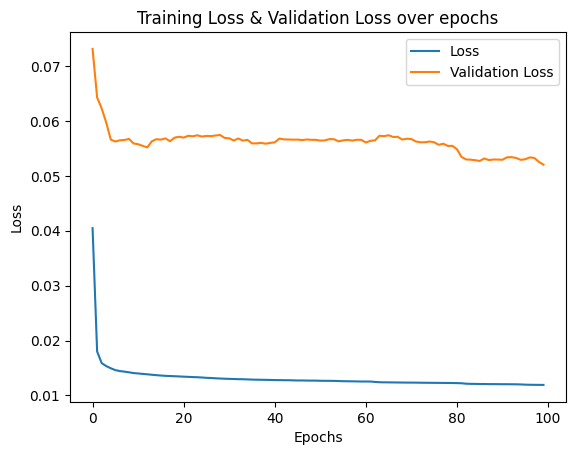

In [12]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Training Loss & Validation Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
#plt.ylim([0,.0008])
plt.legend(["Loss", "Validation Loss"])
plt.show()

In [13]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Tensor("anomaly_detector/sequential/dense_2/Relu:0", shape=(None, 8), dtype=float32)
Tensor("anomaly_detector/sequential_1/dense_5/Sigmoid:0", shape=(None, 46), dtype=float32)
2105/2105 [==============================] - 2s 910us/step
Threshold:  0.04027502


In [14]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [15]:
test_predictions = predict(autoencoder, np_test_data, threshold)

tf.Tensor(
[[0.         0.         1.4514513  ... 1.9212586  3.8576152  0.27906305]
 [0.         0.         1.7471397  ... 2.021806   3.8695154  0.45785522]
 [0.         0.         3.5509353  ... 3.3716967  2.7387593  2.5082252 ]
 ...
 [0.         0.         3.9107456  ... 4.0991173  4.163392   2.8699899 ]
 [0.         0.         3.936584   ... 5.0925922  5.1069193  3.4355702 ]
 [0.         0.         3.0652208  ... 4.5350165  4.1783786  0.38901147]], shape=(22544, 8), dtype=float32)
tf.Tensor(
[[3.0782193e-08 1.3747586e-01 2.1409248e-08 ... 1.8283508e-08
  3.5742044e-03 1.1364049e-01]
 [8.8839247e-09 2.5465074e-03 5.6355391e-09 ... 5.3607252e-09
  4.9498671e-04 4.3301368e-03]
 [2.6103811e-10 5.3332122e-23 1.1181099e-10 ... 1.4195238e-10
  1.0656700e-20 4.1001808e-20]
 ...
 [3.8503393e-12 8.1267819e-23 3.3559631e-12 ... 1.4357136e-11
  2.5916908e-19 9.3390246e-18]
 [1.5332575e-12 1.7922634e-18 4.5226889e-13 ... 1.8723690e-12
  1.8454582e-16 3.4983674e-15]
 [4.3528053e-13 7.7122943e-12 

### Stats for whole dataset

In [16]:
print_stats(test_predictions, test_labels)

Accuracy = 0.7752395315826828
Precision = 0.6606698034874066
Recall = 0.9832149109257543


In [68]:
predicted_anomalous = np_test_data[test_predictions]
predicted_anomalous_labels = np_test_labels[test_predictions]

### Stats for all predicted anomalous data

In [70]:
print_stats(predicted_anomalous, predicted_anomalous_labels)

ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

In [18]:
def addZToData(data, model):
    data_with_Z = []
    for i in range(1, len(data)+1):
        data_with_Z.append(addZToPrediction(model, data[i-1:i]))

    data_with_Z_rf = []
    for i in range(len(data_with_Z)):
        data_with_Z_rf.append(np_train_data[:][:][i].numpy().reshape(1,46).squeeze())

    return  pd.DataFrame(data_with_Z_rf)

In [71]:
train_data_with_Z_df = addZToData(np_train_data, autoencoder)

anomalous_test_data_with_Z_df = addZToData(predicted_anomalous, autoencoder)


KeyboardInterrupt



In [20]:
contamination = sum(train_labels == 0) / len(train_labels)

In [21]:
from turtleIsolationForests.extendedIsolationForest import ExtendedIsolationForest
from turtleIsolationForests.printResults import print_results

eif = ExtendedIsolationForest(contamination = contamination, random_state = None)
eif.fit(train_data_with_Z_df, train_labels)

eif_predictions = eif.predict(anomalous_test_data_with_Z_df)
eif_predictions['is_normal'] = predicted_anomalous_labels

print_results(eif_predictions)

Finished building forest
Finished calculating threshold
true anomalies: 2489
false anomalies: 2415
false normals: 4762
true normals: 4786
precision: 0.5075448613376835
recall: 0.34326299820714384
f1-score: 0.40954339777869186


In [23]:
from turtleIsolationForests.sciForest import SCIsolationForest

scif = SCIsolationForest(contamination = contamination, num_hyperplanes_per_split=5, random_state = None)
scif.fit(train_data_with_Z_df, train_labels)

scif_predictions = scif.predict(anomalous_test_data_with_Z_df)
scif_predictions['is_normal'] = predicted_anomalous_labels

print_results(scif_predictions)

Finished building forest
Finished calculating threshold
true anomalies: 2491
false anomalies: 2413
false normals: 4873
true normals: 4675
precision: 0.507952691680261
recall: 0.3382672460619229
f1-score: 0.40609716335180956


In [26]:
from turtleIsolationForests.isolationForest import IsolationForest

isoforest = IsolationForest(contamination = contamination, random_state = None)
isoforest.fit(train_data_with_Z_df, train_labels)

isoforest_predictions = isoforest.predict(anomalous_test_data_with_Z_df)
isoforest_predictions['is_normal'] = predicted_anomalous_labels

print_results(isoforest_predictions)

true anomalies: 2485
false anomalies: 2419
false normals: 4810
true normals: 4738
precision: 0.5067292006525286
recall: 0.3406442769019877
f1-score: 0.40741044347897365


In [27]:
from turtleIsolationForests.FBIF import FBIsolationForest

fbif = FBIsolationForest(contamination = contamination, random_state = None)
fbif.fit(train_data_with_Z_df, train_labels)

fbif_predictions = fbif.predict(anomalous_test_data_with_Z_df)
fbif_predictions['is_normal'] = predicted_anomalous_labels

print_results(fbif_predictions)

true anomalies: 2471
false anomalies: 2433
false normals: 4867
true normals: 4681
precision: 0.5038743882544862
recall: 0.3367402562005996
f1-score: 0.4036922071556936
